In [1]:
#basic imports and ipython setup


%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

sys.path.append('../MCEq')
os.chdir('..')

#import solver related modules
#import primary model choices
import crflux.models as pm

from MCEq.core import MCEqRun
#from MCEq import config
import MCEq.config as config
from MCEq.particlemanager import MCEqParticle


In [2]:
''' This changes the path MCEq takes to get its decay and particle tables,
# The below options are for the new file sent by Anatoli for SIBYLL2.3d 
# and the updated decays for things like tau
# if you just want the basic MCEq, do not run this cell or the one following MCEqRun
# To use the old MCEq, change branch back to main branch and not new_build_model'''
config.mceq_db_fname = "/opt/anaconda3/lib/python3.12/site-packages/MCEq/data/mceq_db_lext_dpm191_v12.h5"
config.decay_db_name = "full_decays" #or "pythia_decays_K3b_202206"
config.muon_helicity_dependence = True

In [3]:
mceq_run = MCEqRun(
interaction_medium = 'air',
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.HillasGaisser2012, 'H3a'),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=84.25,
#expand the rest of the options from mceq_config.py
#**config
)
mceq_run.set_density_model(('MSIS00_IC', ('SouthPole', "October")))
mag = 3
pman = mceq_run.pman

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'October')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 84.25


In [4]:
'''Also do not run this cell for the old MCEq'''                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
# Re-apply the appropriate databases, hopefully initializes the tables for our added particles
pman.set_cross_sections_db(mceq_run._int_cs)
pman.set_decay_channels(mceq_run._decays)
pman.set_interaction_model(mceq_run._int_cs, mceq_run._interactions)

In [5]:
#What file you want to pull from/save to
run = 2

In [6]:
import numpy as np, gzip, pickle, sys, os
from pathlib import Path

# make the zenith grid and select 3 angles
cos_grid   = np.linspace(np.cos(np.deg2rad(90)), np.cos(np.deg2rad(0)), 21)
wanted_cos = (0.1, 0.5, 0.9)
tol        = 1e-6 #tolerance for selecting angles you want with angles MCEq actually used

# initialize containers & dictionaries - ONLY ELECTRON NEUTRINOS
tot_nue, conv_nue = [], []

data = {
    "avg": {k: None for k in ("nue", "nue_conv")},
}
for c in wanted_cos:
    data[c] = {k: None for k in ("nue", "nue_conv")}

# main loop that solves and fetches the data from mceq_run and stores it
for cosv in cos_grid:
    theta_deg = float(np.degrees(np.arccos(cosv)))
    mceq_run.set_theta_deg(theta_deg)
    mceq_run.solve()

    # ONLY ELECTRON NEUTRINOS (total and conventional)
    nue_t   = mceq_run.get_solution("total_nue",   mag) + mceq_run.get_solution("total_antinue", mag)
    nue_c   = mceq_run.get_solution("conv_nue",   mag) + mceq_run.get_solution("conv_antinue", mag)

    tot_nue.append(nue_t)
    conv_nue.append(nue_c)

    for tgt in wanted_cos:
        if abs(cosv - tgt) < tol:
            d = data[tgt]
            d["nue"], d["nue_conv"] = nue_t, nue_c
            break

# take the averages for electron neutrinos only
data["avg"]["nue"] = np.mean(tot_nue, axis=0)
data["avg"]["nue_conv"] = np.mean(conv_nue, axis=0)

# calculate ratios and store - ONLY FOR ELECTRON NEUTRINOS
# FIX: Handle division by zero by replacing inf/NaN with 1.0
for c in wanted_cos:
    # Avoid division by zero for conventional fluxes
    with np.errstate(divide='ignore', invalid='ignore'):
        nue_ratio = data[c]["nue"] / data["avg"]["nue"]
        nue_conv_ratio = data[c]["nue_conv"] / data["avg"]["nue_conv"]
        
        # Replace inf/NaN with 1.0 (no enhancement)
        nue_ratio = np.nan_to_num(nue_ratio, nan=1.0, posinf=1.0, neginf=1.0)
        nue_conv_ratio = np.nan_to_num(nue_conv_ratio, nan=1.0, posinf=1.0, neginf=1.0)
        
        data[c]["nue_ratio"] = nue_ratio
        data[c]["nue_conv_ratio"] = nue_conv_ratio

# save energy grid in storable object
data["energy"] = mceq_run.e_grid

# FIX: Save to current working directory instead of system temp
#outfile = Path(f"FishPlot_data{run}.pkl.gz")
# Or use an absolute path to your desired directory:
# outfile = Path.home() / f"FishPlot_data{run}.pkl.gz"

#with gzip.open(outfile, "wb") as fh:
    #pickle.dump(data, fh, protocol=pickle.HIGHEST_PROTOCOL)
# ... your previous code ...

# FIX: Save to home directory (always writable)
outfile = Path.home() / f"FishPlot_data{run}.pkl.gz"

with gzip.open(outfile, "wb") as fh:
    pickle.dump(data, fh, protocol=pickle.HIGHEST_PROTOCOL)

print(f"[OK] Saved electron neutrino fish‑plot data → {outfile.resolve()}")

#print(f"[OK] Saved electron neutrino fish‑plot data → {outfile.resolve()}")

MSIS00IceCubeCentered::set_theta(): latitude = -89.86 for zenith angle = 90.00
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 87.13
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 84.26
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 81.37
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 78.46
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 75.52
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 72.54
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 69.51
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 66.42
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 63.26
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 60.00
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 56.63
MSIS00IceCubeCentered::set_theta(): latitude = -90.0

In [7]:
def compute_theory_flux(model_name, energy_grid, particle_types, data, spectral_index):
    """
    Simple astrophysical flux calculator for electron neutrinos
    Assumes a simple E^-γ power law spectrum
    """
    # Convert energy grid to GeV for calculations
    energy_gev = energy_grid  # assuming energy is already in GeV
    
    # Typical astrophysical flux normalization (adjust as needed)
    if "9.5yrs" in model_name:
        # IceCube-like normalization for 9.5 years data
        norm = 1.44e-18  # GeV^-1 cm^-2 s^-1 sr^-1 (typical IceCube value)
    else:
        norm = 1.0e-18
    
    # Power law spectrum: Φ ∝ E^-γ
    gamma = spectral_index if spectral_index else 2.0
    
    # Calculate flux for each energy (simple power law)
    # Normalized at 100 TeV (1e5 GeV)
    flux = norm * (energy_gev / 1e5)**(-gamma)
    
    # Create result dictionary - only for electron neutrinos
    result = {}
    if "nue" in particle_types:
        result["nue"] = flux
    
    # Add energy grid to result for convenience
    result["energy"] = energy_gev
    
    print(f"Calculated astrophysical {model_name} flux with γ={gamma}")
    print(f"Flux at 100 TeV: {norm:.2e} GeV^-1 cm^-2 s^-1 sr^-1")
    
    return result

# Now use it for electron neutrinos only
astro_flux = compute_theory_flux("astro 9.5yrs", data["energy"], ["nue"], data, 2.0)

# You can also calculate with different spectral indices
# astro_flux_2 = compute_theory_flux("astro 9.5yrs", data["energy"], ["nue"], data, 2.2)
# astro_flux_3 = compute_theory_flux("astro 9.5yrs", data["energy"], ["nue"], data, 2.5)
print(f"Astrophysical electron neutrino flux shape: {astro_flux['nue'].shape}")
print(f"Energy range: {data['energy'][0]:.2e} - {data['energy'][-1]:.2e} GeV")

# Compare with atmospheric electron neutrinos at a specific energy
energy_idx = 50  # pick an energy index
print(f"\nAt 1e{np.log10(data['energy'][energy_idx]):.1f} GeV:")
print(f"  Astrophysical νe: {astro_flux['nue'][energy_idx]:.2e}")
print(f"  Atmospheric νe: {data['avg']['nue'][energy_idx]:.2e}")

Calculated astrophysical astro 9.5yrs flux with γ=2.0
Flux at 100 TeV: 1.44e-18 GeV^-1 cm^-2 s^-1 sr^-1
Astrophysical electron neutrino flux shape: (121,)
Energy range: 8.91e-02 - 8.91e+10 GeV

At 1e4.0 GeV:
  Astrophysical νe: 1.81e-16
  Atmospheric νe: 1.12e-03


In [8]:
# Build the zenith grid
cos_spaced = np.linspace(
    np.cos(np.deg2rad(90.)),
    np.cos(np.deg2rad(0.)),
    21,
)
cos_spaced

array([6.123234e-17, 5.000000e-02, 1.000000e-01, 1.500000e-01,
       2.000000e-01, 2.500000e-01, 3.000000e-01, 3.500000e-01,
       4.000000e-01, 4.500000e-01, 5.000000e-01, 5.500000e-01,
       6.000000e-01, 6.500000e-01, 7.000000e-01, 7.500000e-01,
       8.000000e-01, 8.500000e-01, 9.000000e-01, 9.500000e-01,
       1.000000e+00])

In [9]:
# Load in data from FishPlot data file saved in home directory
import gzip, pickle
import numpy as np
from pathlib import Path

# Use the same path where you saved the file
path = Path.home() / f"FishPlot_data{run}.pkl.gz"

with gzip.open(path, "rb") as fh:
    filedata = pickle.load(fh)

print(f"Loaded electron neutrino fish-plot data from: {path}")
print(f"Available keys: {list(filedata.keys())}")
print(f"Energy grid shape: {filedata['energy'].shape}")
print(f"Angles available: {[k for k in filedata.keys() if k != 'energy' and k != 'avg']}")

Loaded electron neutrino fish-plot data from: /Users/gadha/FishPlot_data2.pkl.gz
Available keys: ['avg', 0.1, 0.5, 0.9, 'energy']
Energy grid shape: (121,)
Angles available: [0.1, 0.5, 0.9]


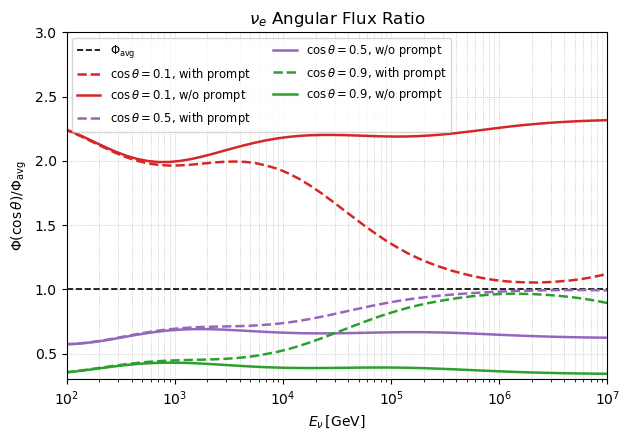

In [10]:
# choose the flavour - ELECTRON NEUTRINOS ONLY
particle = "nue"        # Only "nue" for electron neutrinos


COS_VALS  = (0.1, 0.5, 0.9) # These are thre three angles we select to compare
COLORS    = {0.1: "tab:red", 0.5: "tab:purple", 0.9: "tab:green"}
LATEX_SYM = {"nue": r"\nu_{e}"}  # Only electron neutrino symbol
sym = LATEX_SYM[particle]

energy = filedata["energy"]      # load in the 1-D array energy bins (x-axis)

fig, ax = plt.subplots(figsize=(6.4, 4.5))

# add center line for average flux
ax.axhline(1.0, color="black", ls="--", lw=1.2, label=r"$\Phi_{\mathrm{avg}}$")

# plot both w/ & w/o prompt for each of the three angles
for cosv in COS_VALS:
    col = COLORS[cosv]

    # with prompt (total / average‑total) — dashed
    ax.plot(energy,
            filedata[cosv][f"{particle}_ratio"],
            color=col, lw=1.8, ls="--",
            label=rf"$\cos\theta={cosv:.1f}$, with prompt")

    # without prompt (conventional / average‑conventional) — solid
    ax.plot(energy,
            filedata[cosv][f"{particle}_conv_ratio"],
            color=col, lw=1.8, ls="-",
            label=rf"$\cos\theta={cosv:.1f}$, w/o prompt")

ax.set_xscale("log")
ax.set_xlim(1e2, 1e7)
ax.set_ylim(0.3, 3.0)

ax.set_xlabel(r"$E_{\nu}\,[\mathrm{GeV}]$")
ax.set_ylabel(r"$\Phi(\cos\theta)/\Phi_{\mathrm{avg}}$")
ax.set_title(fr"${sym}$ Angular Flux Ratio")

ax.legend(fontsize="small", ncol=2, frameon=True)
ax.grid(True, which="both", ls=":", lw=0.5)
plt.tight_layout()
plt.show()